## FashionMNIST Dataset

implemented by  PyTorch

In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline

In [55]:
import struct
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optimizer
import random

In [9]:
def read_image_files(filename, num):
    bin_file = open(filename, 'rb')
    buf = bin_file.read()
    index = 0
    magic, numImage, numRows, numCols = struct.unpack_from('>IIII', buf, index)
    index += struct.calcsize('>IIII')

    image_sets = []
    for i in range(num):
        images = struct.unpack_from('>784B', buf, index)
        index += struct.calcsize('>784B')
        images = np.array(images)
        images = images/255.0
        images = images.tolist()
        image_sets.append(images)
    bin_file.close()
    return image_sets


def read_label_files(filename):
    bin_file = open(filename, 'rb')
    buf = bin_file.read()
    index = 0
    magic, nums = struct.unpack_from('>II', buf, index)
    index += struct.calcsize('>II')
    labels = struct.unpack_from('>%sB' % nums, buf, index)
    bin_file.close()
    labels = np.array(labels)
    return labels

def fetch_traingset():
    image_file = 'data/train-images-idx3-ubyte'
    label_file = 'data/train-labels-idx1-ubyte'
    images = read_image_files(image_file,60000)
    labels = read_label_files(label_file)
    return {'images': images,
            'labels': labels}


def fetch_testingset():
    image_file = 'data/t10k-images-idx3-ubyte'
    label_file = 'data/t10k-labels-idx1-ubyte'
    images = read_image_files(image_file,10000)
    labels = read_label_files(label_file)
    return {'images': images,
            'labels': labels}


def get_label(idx):
    labels = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
    return labels[idx]    

Label: Trouser


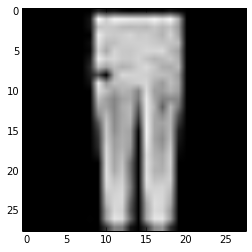

In [13]:
def test():
    data = fetch_testingset()
    image = data['images'][200]
    print("Label: %s" % get_label(data['labels'][200]))
    images = np.reshape(image, [28, 28])
    plt.imshow(images, cmap='gray')
    plt.show()
    
    
test()

In [51]:
class BasicConv(nn.Module):
    
    def __init__(self, in_chan, out_chan, kernel_size, stride, padding):
        super(BasicConv, self).__init__()
        self.conv = nn.Conv2d(in_chan, out_chan,kernel_size=kernel_size, stride=stride,padding=padding, bias=False) # verify bias false
        self.bn = nn.BatchNorm2d(out_chan,eps=0.001,momentum=0.1,affine=True)
        self.relu = nn.ReLU(inplace=False)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class ResInceptionBlock(nn.Module):
    
    def __init__(self, in_chan, out_chan, scale):
        super(ResInceptionBlock, self).__init__()
        self.scale = scale
        self.branch_0 = nn.Sequential(
            BasicConv(in_chan, 32, 1, stride=1, padding=0)
        )
        self.branch_1 = nn.Sequential(
            BasicConv(in_chan, 32, 1, stride=1, padding=0),
            BasicConv(32, 32, 3, stride=1, padding=1)
        )
        
        self.branch_2 = nn.Sequential(
            BasicConv(in_chan, 32, 1, stride=1, padding=0),
            BasicConv(32, 32, 3, stride=1, padding=1),
            BasicConv(32, 32, 3, stride=1, padding=1)
        )
        self.out_conv = nn.Conv2d(32*3, out_chan, 1, stride=1, padding=0)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x0 = self.branch_0(x)
        x1 = self.branch_1(x)
        x2 = self.branch_2(x)
        out = torch.cat((x0, x1, x2), 1)
        out = self.out_conv(out)
        out = out * self.scale + x
        out = self.relu(out)
        return out
    
        
class Classifier(nn.Module):
    
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = BasicConv(1, 32, 1, 1, 0)
        self.res_incep_block_1 = ResInceptionBlock(32, 32, 1.0)
        self.res_incep_block_2 = ResInceptionBlock(32, 32, 1.0)        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(32*7*7, 512)
        self.output = nn.Linear(512, 10)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.res_incep_block_1(out)
        out = self.pool(out)
        out = self.res_incep_block_2(out)
        out = self.pool(out)
        out = out.view(-1, 32*7*7)
        out = F.leaky_relu(self.fc(out), 0.3)
        out = F.softmax(self.output(out))
        return out


In [41]:
data = fetch_testingset()

samples = data['images'][0:10]
print(len(samples))

10


In [42]:
samples = [np.reshape(image, [28, 28]) for image in samples]
samples = np.array(samples)
print(samples.shape)

(10, 28, 28)


In [43]:
input_sample = Variable(torch.FloatTensor(samples))

In [44]:
input_sample = input_sample.unsqueeze(1)
print(input_sample.size())


torch.Size([10, 1, 28, 28])


In [54]:
def save_model(path, model):
    torch.save(model.state_dict(), path)

def load_model(path):
    return torch.load(path)


In [66]:
def test(model, test_data):
    num_samples = len(test_data)
    result = []
    for i in range(num_samples):
        image = test_data[i]
        image = np.reshape(image, [28,28])
        image = Variable(torch.FloatTensor(image))
        image = image.unsqueeze(0)
        image = image.unsqueeze(0)
        prob = model(image)

        prob = prob.squeeze(0)
        prob = prob.data.numpy()
        result.append(prob)

        
def evaluate(pred, truth):
    nums = len(pred)
    correct = 0
    for i in range(nums):
        pred_id = np.argmax(pred[i])
        if pred_id == truth[i]:
            correct += 1

    acc = float(correct)/float(nums)
    print("TEST ACC: %s" % acc)
    return acc

In [67]:
def train(epoches, lr, batch_size, train_data, test_data):
    num_samples = len(train_data)
    classifier = Classifier()
    criterion = nn.CrossEntropyLoss()
    classifier_optimizer = optimizer.Adam(lr=lr, params=classifier.parameters())
    test_labels = test_data['labels']
    test_data = test_data['images']
    for i in xrange(epoches):
        random.shuffle(train_data)
        loss = 0.0
        for p in xrange(num_samples/batch_size):
            images = [np.reshape(img[0], [28,28]) for img in train_data[p: p+batch_size]]
            label = [img[1] for img in train_data[p: p+batch_size]]
            images = Variable(torch.FloatTensor(images))
            label = Variable(torch.LongTensor(label))
            images = images.unsqueeze(1)
            
            prob = classifier(images)
            cur_loss = criterion(prob, label)
            loss += cur_loss.data.numpy()[0]
            classifier_optimizer.zero_grad()
            cur_loss.backward()
            classifier_optimizer.step()
            
            if p % 5 == 0:
                print("Epoch: %s BatchIndex: %s AvgLoss: %s" % (i, p, loss/(p + 1)))
        
        save_model('param/model_%s.pkl' % i, classifier)

        resulclassifierst(classifier, test_data)
        evaluate(result, labels)
        

In [57]:
trainset = fetch_traingset()
train_data = trainset['images']
train_labels = trainset['labels']
train_data = zip(train_data, train_labels)

In [63]:
testset = fetch_testingset()